In [1]:
import sys
sys.path.append('../')
import pdb
import pycm
from glob import glob
import torch
from torch import nn
import cv2
import os
from PIL import Image
from skimage import io, transform
import matplotlib.pyplot as plt
import seaborn as sn
from models import Model
import matplotlib.image as mpimg
import pandas as pd
from torchvision.datasets.folder import pil_loader
import random
import numpy as np
from torchsummary import summary
import pretrainedmodels
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import *
from tensorboard_logger import * 
from dataloader import *
from submission import *
from albumentations import torch as AT
from pycm import *
from confusion_matrix_pretty_print import pretty_plot_confusion_matrix
os.environ['CUDA_VISIBLE_DEVICES']=""
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

#### The notebook can be used to analyse predictions of trained models on train set. Test set predictions of two models can also be compared.
See, we can compare the cm obj files saved for train and val for each epoch but dude the dataloader is doing weighted sampling, we don't actually get to see the predictions on the real training set, so yeah let them be for logger.py

In [27]:
def get_uniques(path):
    '''takes predicted csv's and returns unique counts'''
    pred = pd.read_csv(path)
    print(np.unique(pred.diagnosis.values, return_counts=True))

# def get_preds(pred, threshold):
#     '''pred: [nx5], threshold: float'''
#     y1 = pred > threshold
#     y1 = np.clip(y1.astype(int).sum(axis=1) - 1, 0, 4)
#     return y1

def get_preds(arr, threshold, num_cls=5):
    """ takes in thresholded predictions (num_samples, num_cls) and returns (num_samples,)
    [3], arr needs to be a numpy array, NOT torch tensor"""
    arr = arr > threshold
    mask = arr == 0
    # pdb.set_trace()
    return np.clip(np.where(mask.any(1), mask.argmax(1), num_cls) - 1, 0, num_cls - 1)


def predict(X, coef):
    # [0.15, 2.4, ..] -> [0, 2, ..]
    X_p = np.copy(X)
    for i, pred in enumerate(X_p):
        if pred < coef[0]:
            X_p[i] = 0
        elif pred >= coef[0] and pred < coef[1]:
            X_p[i] = 1
        elif pred >= coef[1] and pred < coef[2]:
            X_p[i] = 2
        elif pred >= coef[2] and pred < coef[3]:
            X_p[i] = 3
        else:
            X_p[i] = 4
    return X_p.astype('int')



In [28]:
get_uniques('../weights/submission713.csv') 
get_uniques('../weights/submission736.csv') 
get_uniques('../weights/submission73.csv') 
get_uniques('../weights/submission785.csv') 
get_uniques('../weights/submission812.csv') 

(array([0, 1, 2, 3, 4]), array([227, 416, 931, 316,  38]))
(array([0, 1, 2, 3, 4]), array([292, 344, 998, 229,  65]))
(array([0, 1, 2, 3, 4]), array([ 301,  227, 1002,  345,   53]))
(array([0, 1, 2, 3, 4]), array([ 292,  180, 1178,  220,   58]))
(array([0, 1, 2, 3, 4]), array([ 331,  195, 1145,  193,   64]))


##### Load predicted test npy files and compute the optimized threshold using the best public submission.csv

In [20]:
#npy_folder = '../weights/15-7_resnext101_32x4d_v0_fold0_bgcpold256/test_npy/'
#npy_folder = '../weights/17-7_resnext101_32x4d_v0_fold0_bgcpcold256reg/test_npy/'
#npy_folder = '../weights/18-7_resnext101_32x16d_fold0_bgccpold/test_npy/'
npy_folder = '../weights/21-7_efficientnet-b5_fold1_bgccpo300/test_npy/'
files = glob(os.path.join(npy_folder, '*.npy'))
preds = {}
for file in files:
    ep = file.split('/')[-1]
    preds[ep] = np.load(file)
#preds.keys()

In [21]:
y_test = pd.read_csv('../weights/submission812.csv')['diagnosis'].values.reshape(-1, 1)

In [22]:
#cohen_kappa_score(y_test1, y_test, weights="quadratic")

In [23]:

def compute_dist(threshold, pred):
    y1 = get_preds(pred, threshold)
    #distance = np.mean((y1 - y_test)**2)
    score = cohen_kappa_score(y1, y_test, weights='quadratic')
    return 1 - score

def get_optimised_threshold(pred):
    initial_coeffs = np.array([0.5, 0.5, 0.5, 0.5, 0.5])
    simplex = scipy.optimize.minimize(
        compute_dist, initial_coeffs, args=(pred,), method='nelder-mead'
    )
    best_threshold = simplex['x']
    return best_threshold

for key in sorted(preds.keys(), key=lambda x: int(x.split('.')[0][9:])):
    pred, val_bt = preds[key]# val_bt = validation best threhsold
    #best_threshold = get_optimised_threshold(pred)
    best_threshold = val_bt
    base_threshold = np.array([0.5, 1.5, 2.5, 3.5])
    #print(f"\nval best thr: {val_bt}")
    print(f'\n{key}: {best_threshold}')
    pred1 = predict(pred, best_threshold)
    pred2 = predict(pred, base_threshold)
    score = cohen_kappa_score(y_test, pred1, weights="quadratic")
    acc = accuracy_score(y_test, pred1)
    print(f'score: {score}, acc: {acc}')
    print('best:', np.unique(pred1, return_counts=True)[1])
    print('base:', np.unique(pred2, return_counts=True)[1])


test_ckpt0.npy: [0.56296546 1.49145511 2.21626788 3.28031107]
score: 0.8337252571325161, acc: 0.6763485477178424
best: [323 147 837 592  29]
base: [ 305  167 1173  283]

test_ckpt1.npy: [0.4947449  1.56182673 2.40311978 3.4877262 ]
score: 0.8803778633618288, acc: 0.7894190871369294
best: [ 322  194 1023  364   25]
base: [ 322  166 1126  290   24]

test_ckpt2.npy: [0.528125 1.584375 2.40625  3.215625]
score: 0.8878795428838534, acc: 0.7971991701244814
best: [ 316  215 1021  319   57]
base: [ 313  172 1148  271   24]

test_ckpt3.npy: [0.53141623 1.5988492  2.31858349 3.51409445]
score: 0.8911973682284742, acc: 0.8049792531120332
best: [322 221 983 384  18]
base: [ 314  179 1176  239   20]

test_ckpt4.npy: [0.53902435 1.58301544 2.36747742 3.33385468]
score: 0.8951547120561205, acc: 0.8054979253112033
best: [326 216 973 366  47]
base: [ 322  181 1112  286   27]

test_ckpt5.npy: [0.51441325 1.5264832  2.40943208 3.40612546]
score: 0.8966106708904562, acc: 0.8091286307053942
best: [320 192

In [24]:
pred, th = preds['test_ckpt17.npy']
best_threshold = [0.5, 1.5, 2.5, 3.5]
pred_ = predict(pred, best_threshold)
print(np.unique(pred_, return_counts=True))
pred_ = predict(pred, th)
print(np.unique(pred_, return_counts=True))


(array([0, 1, 2, 3, 4]), array([ 308,  346, 1000,  181,   93]))
(array([0, 1, 2, 3, 4]), array([ 303,  296, 1048,  206,   75]))


In [19]:
state = torch.load('../weights/19-7_efficientnet-b5_fold3_bgccpold/ckpt39.pth',  map_location='cpu')
state['best_thresholds']

array([0.51194226, 1.61039147, 2.35353369, 3.35449956])

#### Analysis of model on train/val sets

In [2]:
train_cm = ConfusionMatrix(file=open('../weights/19-7_efficientnet-b5_fold1_bgccpold/logs/cmtrain_10.obj', 'r'))
val_cm = ConfusionMatrix(file=open('../weights/19-7_efficientnet-b5_fold1_bgccpold/logs/cmval_10.obj', 'r'))

In [6]:
ConfusionMatrix?

In [8]:
train_cm.predict_vector

In [3]:
train_cm.print_matrix()

Predict    0          1          2          3          4          
Actual
0          1904       77         6          1          0          

1          83         212        146        4          2          

2          16         88         839        123        1          

3          1          3          116        234        29         

4          0          1          45         82         118        




In [5]:
val_cm.print_matrix()

Predict   0         1         2         3         4         
Actual
0         314       11        1         0         0         

1         17        31        19        1         0         

2         3         18        131       8         0         

3         0         0         27        28        8         

4         0         0         9         11        18        




Effnet fold1, ckpt10 is my best performing model so far. LB: 0.812, 
Things to notice:
* Val thresholds optimized were used for val metric val_cm.

In [10]:
val_cm.overall_stat

{'Overall ACC': 0.7969465648854962,
 'Kappa': 0.6912228094240578,
 'Overall RACC': 0.3423949653283608,
 'SOA1(Landis & Koch)': 'Substantial',
 'SOA2(Fleiss)': 'Intermediate to Good',
 'SOA3(Altman)': 'Good',
 'SOA4(Cicchetti)': 'Good',
 'SOA5(Cramer)': 'Strong',
 'SOA6(Matthews)': 'Moderate',
 'TPR Macro': 0.6311902383922033,
 'PPV Macro': 0.6865924424290046,
 'ACC Macro': 0.9187786259541983,
 'F1 Macro': 0.6515875767370725,
 'TPR Micro': 0.7969465648854962,
 'PPV Micro': 0.7969465648854962,
 'F1 Micro': 0.7969465648854962,
 'Scott PI': 0.6908869944734718,
 'Gwet AC1': 0.7570484093907909,
 'Bennett S': 0.7461832061068702,
 'Kappa Standard Error': 0.023901986262936624,
 'Kappa 95% CI': (0.644374916348702, 0.7380707024994135),
 'Chi-Squared': 1028.5943993206718,
 'Phi-Squared': 1.57037312873385,
 'Cramer V': 0.6265726471714692,
 'Chi-Squared DF': 16,
 '95% CI': (0.7661391545353836, 0.8277539752356088),
 'Standard Error': 0.015718066505159483,
 'Response Entropy': 1.788741071801734,
 'Ref

In [9]:
np.mean(list(val_cm.class_stat['TPR'].values()))

0.6311902383922033

In [ ]:
def get_cms(pred_csv_path, fold, total_folds):
    '''useless, use cm_obj files instead'''
    '''takes predicted csv and fold, returns confusion matrices of train and validation set for that predictions'''
    preds = pd.read_csv(pred_csv_path)
    actual = pd.read_csv('../data/train.csv')
    df = preds.copy()
    df['pred'] = preds['diagnosis']
    df['actual'] = actual['diagnosis']
    df = df.drop('diagnosis', axis=1)
    # use `fold` to get the indices of train and val images in the actual df
    bad_indices = np.load('../data/bad_train_indices.npy')
    actual = actual.drop(df.index[bad_indices]) # remove duplicates having diff diagnosis
    kfold = StratifiedKFold(total_folds, shuffle=True, random_state=69)  # 20 splits
    train_idx, val_idx = list(kfold.split(actual["id_code"], actual["diagnosis"]))[fold]
    train_df, val_df = df.iloc[train_idx], df.iloc[val_idx]
    
    train_cm = ConfusionMatrix(train_df.actual.values, train_df.pred.values)
    val_cm = ConfusionMatrix(val_df.actual.values, val_df.pred.values)
    
    return train_cm, val_cm

In [ ]:
pred_csv_path = '../weights/10-7_densenet121_fold0_bengrahmscolor/ckpt38.csv'
fold = 0
total_folds=5
train_cm, val_cm = get_cms(pred_csv_path, fold, total_folds)

In [84]:
train_cm = ConfusionMatrix(file=open('../weights/8-7_resnext101_32x4d_fold6/logs/cmtrain_35.obj', 'r'))
val_cm = ConfusionMatrix(file=open('../weights/8-7_resnext101_32x4d_fold6/logs/cmval_35.obj', 'r'))

In [83]:
train_cm.print_matrix()

Predict    0          1          2          3          4          
Actual
0          1287       27         3          0          0          

1          20         465        53         2          13         

2          8          63         587        29         29         

3          0          1          35         203        30         

4          4          15         53         32         266        




In [85]:
val_cm.print_matrix()

Predict   0         1         2         3         4         
Actual
0         175       2         0         0         0         

1         2         26        6         0         2         

2         3         19        61        10        5         

3         0         0         3         10        6         

4         0         2         8         1         17        




In [34]:
cm = val_cm
cm.matrix

{0: {0: 314, 1: 11, 2: 1, 3: 0, 4: 0},
 1: {0: 17, 1: 31, 2: 19, 3: 1, 4: 0},
 2: {0: 3, 1: 18, 2: 131, 3: 8, 4: 0},
 3: {0: 0, 1: 0, 2: 27, 3: 28, 4: 8},
 4: {0: 0, 1: 0, 2: 9, 3: 11, 4: 18}}

In [35]:
cm.TP, cm.FP, cm.TN, cm.FN

({0: 314, 1: 31, 2: 131, 3: 28, 4: 18},
 {0: 20, 1: 29, 2: 56, 3: 20, 4: 8},
 {0: 309, 1: 558, 2: 439, 3: 572, 4: 609},
 {0: 12, 1: 37, 2: 29, 3: 35, 4: 20})

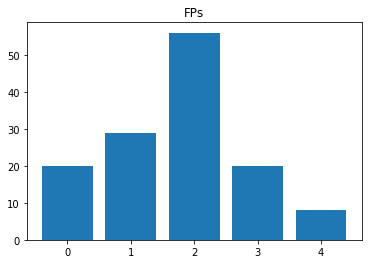

In [47]:
plt.bar(cm.FP.keys(), cm.FP.values())
plt.title('FPs');

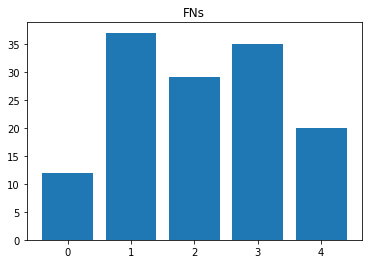

In [48]:
plt.bar(cm.FN.keys(), cm.FN.values())
plt.title('FNs');

##### Analysing train set predictions

In [60]:
train_pred = pd.read_csv('../weights/19-7_efficientnet-b5_fold1_bgccpold/ckpt10train.csv') # generated using submission.py on whole train set
train_actual = pd.read_csv('../data/train.csv')
df = train_pred.copy()
df['pred'] = train_pred['diagnosis']
df['actual'] = train_actual['diagnosis']
df = df.drop('diagnosis', axis=1)
df.head()

,id_code,pred,actual
0,000c1434d8d7,2,2
1,001639a390f0,4,4
2,0024cdab0c1e,1,1
3,002c21358ce6,0,0
4,005b95c28852,0,0


In [106]:
cm = ConfusionMatrix(df['actual'].values, df['pred'].values)

In [109]:
print(cm)

Predict    0          1          2          3          4          
Actual
0          1790       14         1          0          0          

1          15         204        148        2          1          

2          0          46         928        25         0          

3          0          1          86         87         19         

4          0          1          65         61         168        





Overall Statistics : 

95% CI                                                            (0.85658,0.87854)
ACC Macro                                                         0.94702
AUNP                                                              0.91456
AUNU                                                              0.83214
Bennett S                                                         0.83445
CBA                                                               0.6638
Chi-Squared                                                       7422.08847
Chi-Squared DF               

In [110]:
cm.class_stat

{'TPR': {0: 0.9916897506925207,
  1: 0.5513513513513514,
  2: 0.928928928928929,
  3: 0.45077720207253885,
  4: 0.5694915254237288},
 'TNR': {0: 0.9919224555735057,
  1: 0.9811664641555286,
  2: 0.8873450995118287,
  3: 0.9746324589218796,
  4: 0.994059994059994},
 'PPV': {0: 0.9916897506925207,
  1: 0.7669172932330827,
  2: 0.755700325732899,
  3: 0.49714285714285716,
  4: 0.8936170212765957},
 'NPV': {0: 0.9919224555735057,
  1: 0.9511189634864546,
  2: 0.9708299096138044,
  3: 0.9696013765414396,
  4: 0.9634427173287277},
 'FNR': {0: 0.008310249307479256,
  1: 0.4486486486486486,
  2: 0.07107107107107102,
  3: 0.5492227979274611,
  4: 0.43050847457627117},
 'FPR': {0: 0.008077544426494332,
  1: 0.01883353584447145,
  2: 0.11265490048817128,
  3: 0.025367541078120448,
  4: 0.005940005940005988},
 'FDR': {0: 0.008310249307479256,
  1: 0.23308270676691734,
  2: 0.24429967426710097,
  3: 0.5028571428571429,
  4: 0.1063829787234043},
 'FOR': {0: 0.008077544426494332,
  1: 0.0488810365135

In [111]:
cm.overall_stat

{'Overall ACC': 0.8675587110868378,
 'Kappa': 0.796736978861479,
 'Overall RACC': 0.34842408534848435,
 'SOA1(Landis & Koch)': 'Substantial',
 'SOA2(Fleiss)': 'Excellent',
 'SOA3(Altman)': 'Good',
 'SOA4(Cicchetti)': 'Excellent',
 'SOA5(Cramer)': 'Strong',
 'SOA6(Matthews)': 'Strong',
 'TPR Macro': 0.6984477516938137,
 'PPV Macro': 0.781013449615591,
 'ACC Macro': 0.947023484434735,
 'F1 Macro': 0.7270171235907253,
 'TPR Micro': 0.8675587110868378,
 'PPV Micro': 0.8675587110868378,
 'F1 Micro': 0.8675587110868378,
 'Scott PI': 0.7962996935039082,
 'Gwet AC1': 0.8418527836781052,
 'Bennett S': 0.8344483888585471,
 'Kappa Standard Error': 0.008596802399147197,
 'Kappa 95% CI': (0.7798872461591505, 0.8135867115638075),
 'Chi-Squared': 7422.088468068443,
 'Phi-Squared': 2.026785491007221,
 'Cramer V': 0.7118260832196339,
 'Chi-Squared DF': 16,
 '95% CI': (0.8565798310896845, 0.8785375910839911),
 'Standard Error': 0.005601469386302678,
 'Response Entropy': 1.7360455729445294,
 'Reference E

In [61]:
val_df = df # because, I'm lazy huh

In [62]:
diff = val_df[val_df['actual'] != val_df['pred']]

In [63]:
diff.head()

,id_code,pred,actual
13,0104b032c141,2,3
32,0243404e8a00,2,4
40,0318598cfd16,2,4
45,0369f3efe69b,2,1
46,03747397839f,3,2


In [107]:
diff.describe()

,pred,actual
count,485.000000,485.000000
mean,2.074227,2.338144
std,0.770489,1.273169
min,0.000000,0.000000
25%,2.000000,1.000000
50%,2.000000,2.000000
75%,2.000000,4.000000
max,4.000000,4.000000


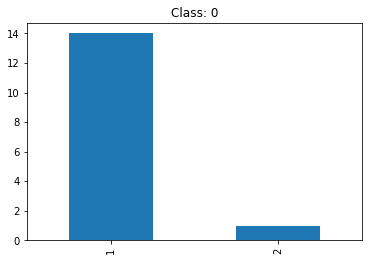

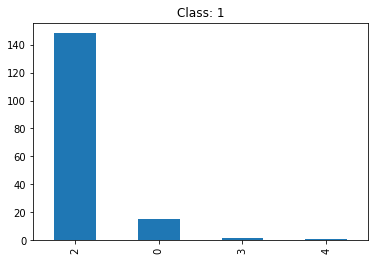

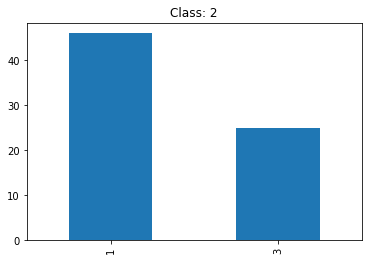

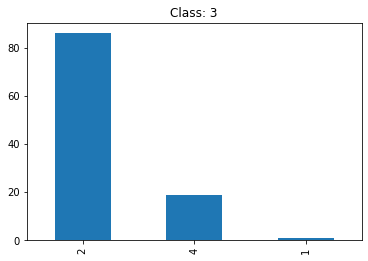

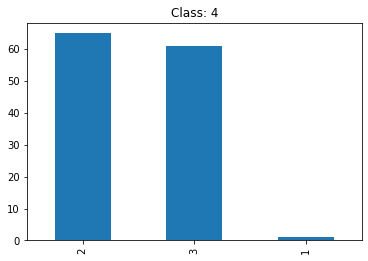

In [103]:
diff[diff['actual']==0]['pred'].value_counts().plot(kind="bar", title='Class: 0'); plt.show()
diff[diff['actual']==1]['pred'].value_counts().plot(kind="bar", title='Class: 1'); plt.show()
diff[diff['actual']==2]['pred'].value_counts().plot(kind="bar", title='Class: 2'); plt.show()
diff[diff['actual']==3]['pred'].value_counts().plot(kind="bar", title='Class: 3'); plt.show()
diff[diff['actual']==4]['pred'].value_counts().plot(kind="bar", title='Class: 4'); plt.show()

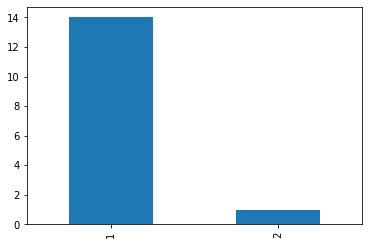

In [93]:
diff[diff['actual']==0]['pred'].value_counts().plot(kind="bar");

### Let's plot some mispredictions

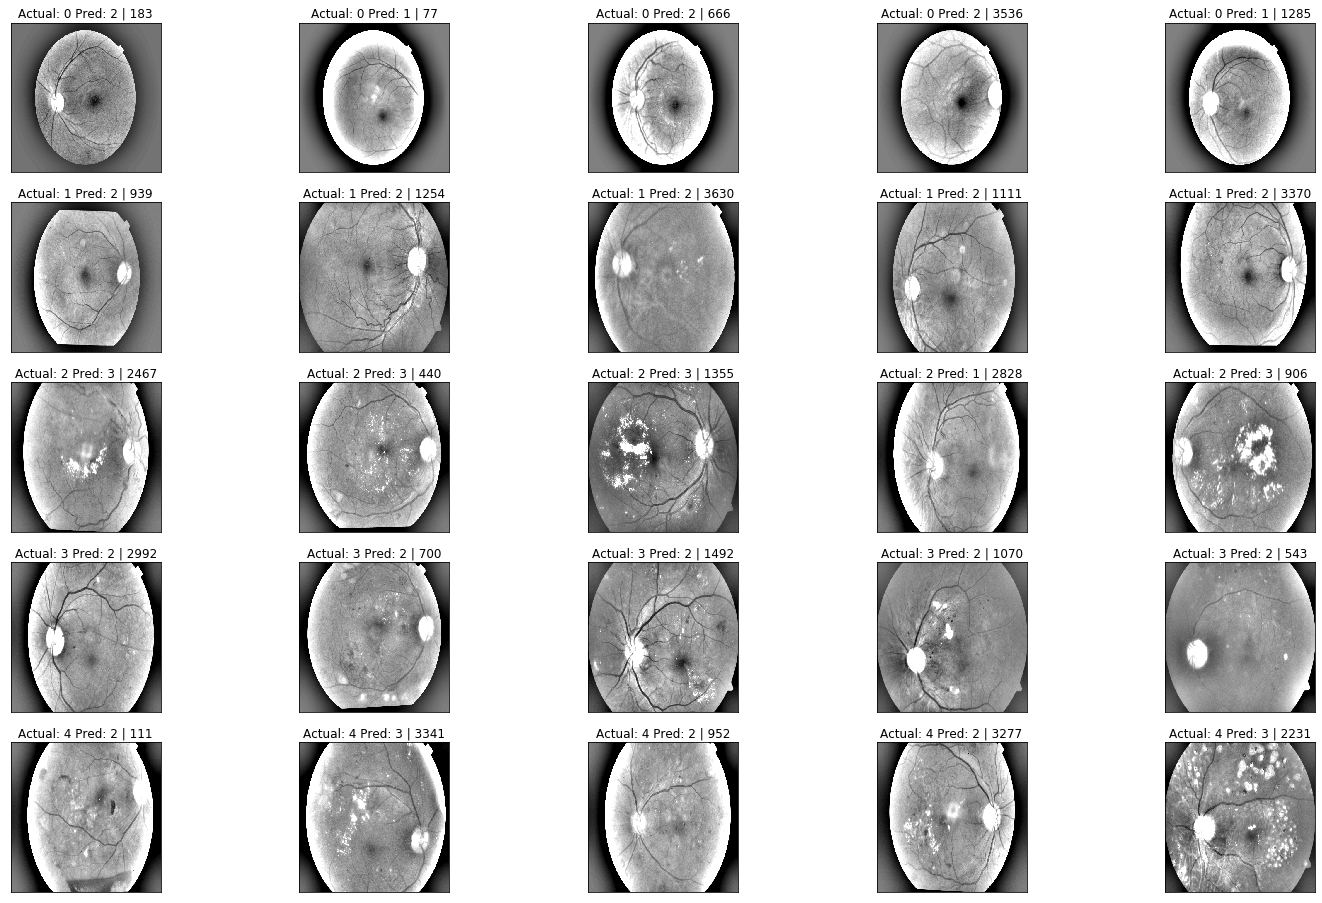

In [18]:
fig = plt.figure(figsize=(25, 16))
IMG_SIZE=512
for class_id in sorted(diff['actual'].unique()):
    samples = len(diff[diff['actual'] == class_id])
    samples = 5 if samples > 5 else samples # make sure there are atleast 5 predictions to plot or go for whatever is available
    for i, (idx, row) in enumerate(diff.loc[diff['actual'] == class_id].sample(samples, random_state=69).iterrows()):
        ax = fig.add_subplot(5, 5, class_id * 5 + i + 1, xticks=[], yticks=[])
        path=f"../data/train_images/{row['id_code']}.png"
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
        image=cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , IMG_SIZE/10) ,-4 ,128) # the trick is to add this line
        plt.imshow(image, cmap='gray')
        ax.set_title('Actual: %d Pred: %d | %s' % (class_id, row['pred'], idx) )

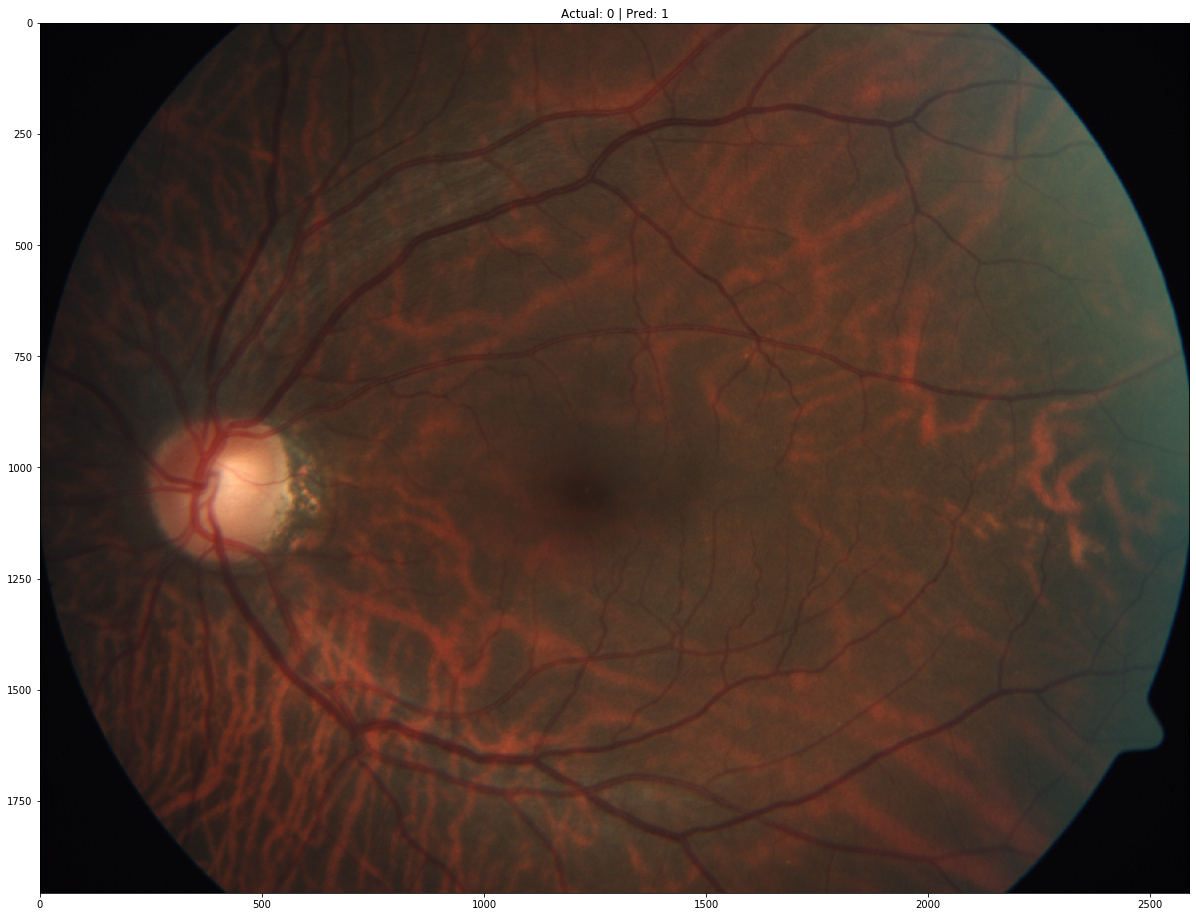

In [86]:
#i = 1546 
i = 494
#img = mpimg.imread() # remember the indices of diff are same as df
path = '../data/train_images/' + df.iloc[i]['id_code'] + '.png'
image = cv2.imread(path)
#image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
#|image=cv2.addWeighted (image, 4, cv2.GaussianBlur( image , (0,0) , IMG_SIZE/10) ,-4 ,128) # the trick is to add this line
fig = plt.figure(figsize=(25, 16))
#plt.imshow(image, cmap='gray')
plt.imshow(image, )
plt.title("Actual: %d | Pred: %d" % (df.iloc[i]['actual'], df.iloc[i]['pred']))
plt.show()

#####  https://www.eyeops.com/contents/our-services/eye-diseases/diabetic-retinopathy

In [87]:
image = cv2.resize(image, (IMG_SIZE, IMG_SIZE, 3))


TypeError: function takes exactly 2 arguments (3 given)

### Base model Activation heatmaps

In [9]:
# Visualize feature maps
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook


In [10]:
model_name = "densenet121"
model = Model(model_name, 5)

In [11]:
model.model.features.norm5.register_forward_hook(get_activation('norm5'))

In [12]:
fold =0
total_folds = 10
images_folder = '../data/train_images/'
df_path = '../data/train.csv'
size = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
dataloaders = {
    phase: provider(
        fold,
        total_folds,
        images_folder,
        df_path,
        phase,
        size,
        mean,
        std,
        batch_size=1,
        num_workers=1,
    )
    for phase in ["train", "val"]
}

def unnormalize(img):
    mean = torch.as_tensor([0.485, 0.456, 0.406])
    std = torch.as_tensor([0.229, 0.224, 0.225])
    #return (img * std) + mean
    for t, m, s in zip(img, mean, std):    
        t.mul_(s).add_(m)
    return img.permute(1, 2, 0)# * 255

In [51]:
batch = next(iter(dataloaders['train']))

In [52]:
fnames, images, labels = batch
output = model(images) # during forward pass, model populates the activation dictionary using forward hook

In [53]:
act = activation['norm5'] # 1, 1024, 7, 7
mean_act = torch.mean(act[0], 0) # take mean across 1024 channels

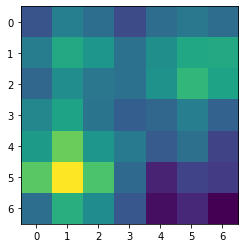

In [54]:
plt.imshow(mean_act, cmap='viridis')

In [55]:
unimage = unnormalize(images[0].clone())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


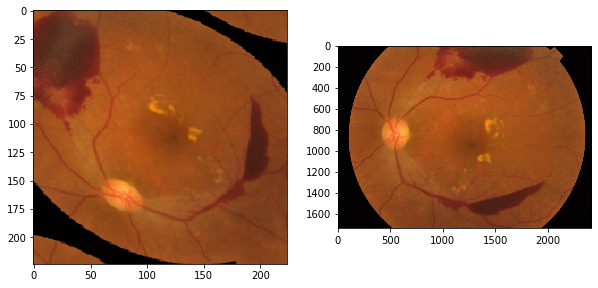

In [63]:
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(unimage);
plt.subplot(1, 2, 2)
plt.imshow(mpimg.imread(f'../data/train_images/{fnames[0]}.png')); 
plt.show(); # original image

In [84]:
torch.max(unimage), torch.min(unimage)

(tensor(0.8902), tensor(0.))

In [87]:
torch.max(images), torch.min(images)

(tensor(1.7694), tensor(-2.1179))